In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

In [43]:
cv2.__version__

'4.5.3'

# Задание 6 #

## Сопоставление точек ##

В общем, я сфотографировал абажуры для люстры на телефон (одной и той же камерой) с двух немного разных ракурсов и теперь хочу сопоставить и найти общую точку.

In [44]:
im1 = cv2.imread('1.jpg')
im2 = cv2.imread('2.jpg')

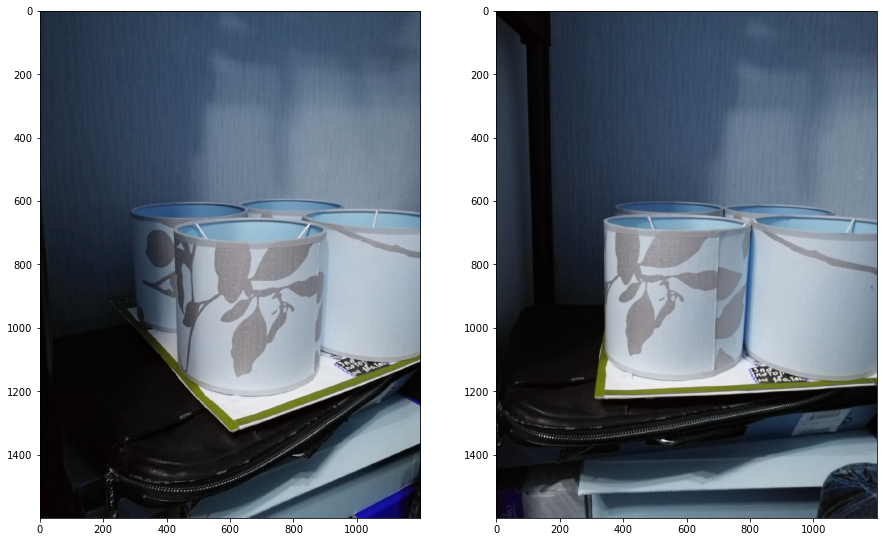

In [45]:
fig, ax = plt.subplots( 1, 2, figsize = (15, 15) )
ax[0].imshow(im1)
ax[1].imshow(im2)

### Вариант 1 - по шаблону ###

In [46]:
# используется шаблон template

In [47]:
template = im1[910:955, 745:800]
# пусть это будет какой-то причудливый узор, который, вроде бы, нигде больше не повторяется

(<matplotlib.image.AxesImage at 0x23ce7a0ee50>, (45, 55, 3))

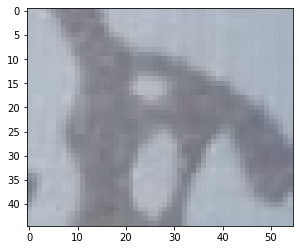

In [48]:
plt.imshow(template), template.shape

Использование функции cv2.matchTemplate

In [49]:
matched = cv2.matchTemplate( im2, template, cv2.TM_CCORR_NORMED)

In [50]:
matched.shape

(1556, 1146)

Карта корреляции - смысла особого в ней нет.

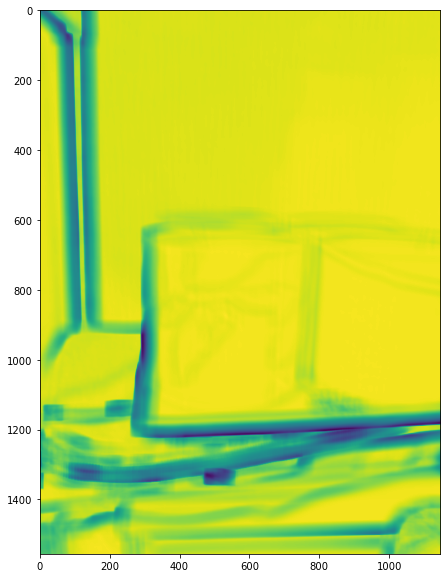

In [51]:
fig = plt.figure(figsize = (10, 10) )
plt.imshow(matched)

А вот здесь показано несколько точек, которые похожи на шаблон с коэффициентом корреляции >, чем 0.995.

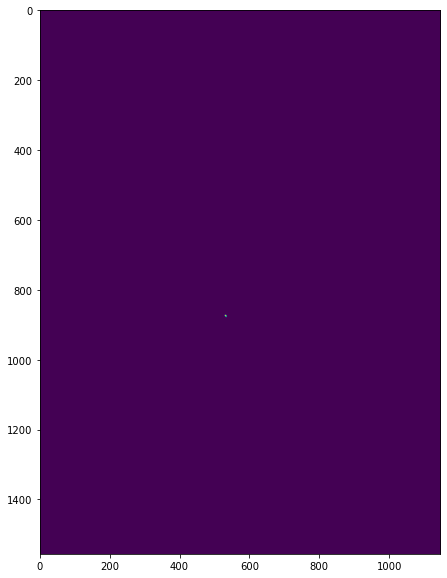

In [52]:
fig = plt.figure(figsize = (10, 10) )
#plt.imshow(matched)
plt.imshow(matched > 0.995)

Видна маленькая точка на координатах ~(900, 550).

In [53]:
points = np.where( matched > 0.996 )
len( points[0] )

12

In [54]:
points

(array([873, 873, 873, 874, 874, 874, 874, 875, 875, 875, 876, 876],
       dtype=int64),
 array([529, 530, 531, 529, 530, 531, 532, 530, 531, 532, 531, 532],
       dtype=int64))

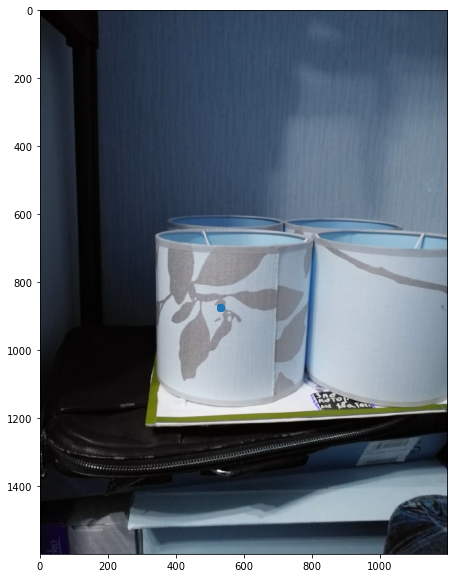

In [55]:
fig = plt.figure(figsize = (10, 10) )
plt.imshow( im2 )
plt.plot( points[1], points[0], "o");

На самом деле видно, что шаблон показал верхний левый угол, так что **надо чуть изменить и центрировать точку.**

(<matplotlib.image.AxesImage at 0x23ce99d7c40>, (45, 55, 3))

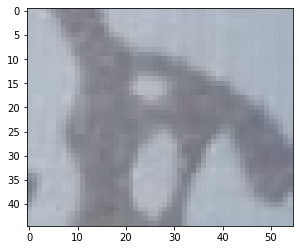

In [56]:
plt.imshow(template), template.shape

Поскольку шаблон имеет форму (45, 55, 3), то надо сделать так:


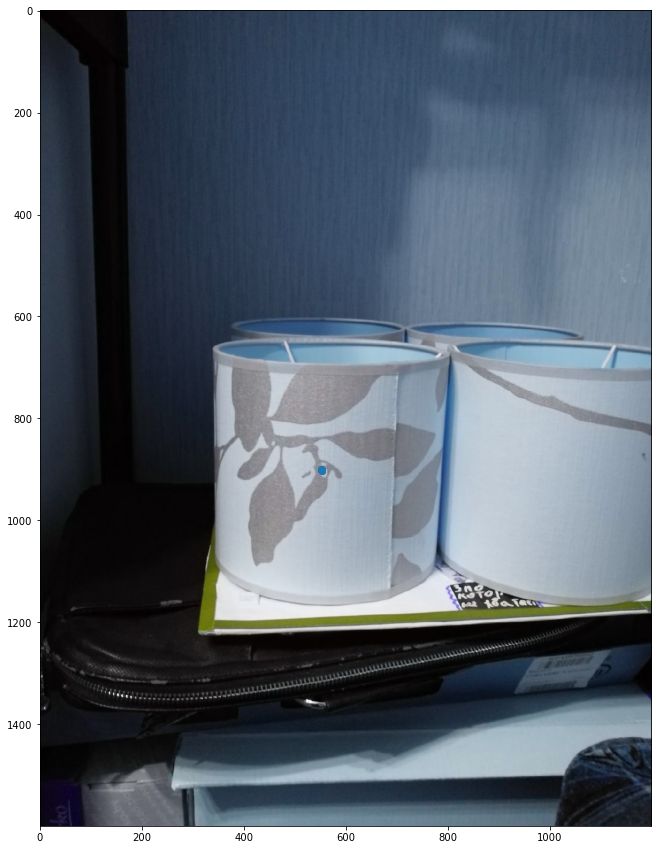

In [57]:
fig = plt.figure(figsize = (15, 15) )
plt.imshow( im2 )
plt.plot( (points[1] + 45//2), (points[0]+55//2), "o");

Вот теперь попадание ровно в центр шаблона.

### Вариант 2 - при помощи метода SIFT ###

Сначала нужно перевести из 3-х каналов в один.

In [58]:
im1_gray = cv2.cvtColor( im1.copy(), cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor( im2.copy(), cv2.COLOR_RGB2GRAY)

Далее выделение интересующей области.

In [59]:
im1_main = im1_gray[600:1200, 400:900]
im2_main = im2_gray[600:1200, 320:820]

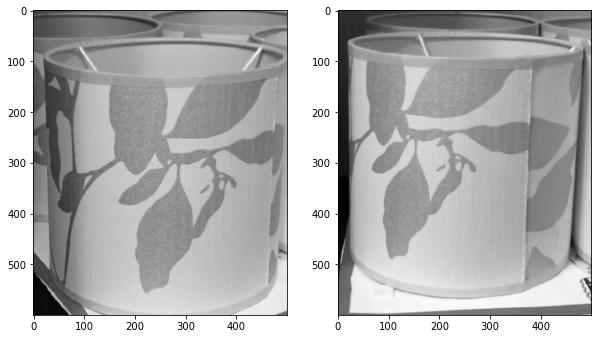

In [60]:
fig, ax = plt.subplots( 1, 2, figsize = (10, 10) )
ax[0].imshow( im1_main, cmap = 'gray' )
ax[1].imshow( im2_main, cmap = 'gray' )

In [61]:
# создание экземпляра класса SIFT
sift = cv2.SIFT_create()

Поиск ключевых точек и дескрипторов.

In [62]:
kpts, desc = sift.detectAndCompute( im1_main, None) # -> keypoints, descriptors
kpts2, desc2 = sift.detectAndCompute( im2_main, None)

Визуализация полученных точек.

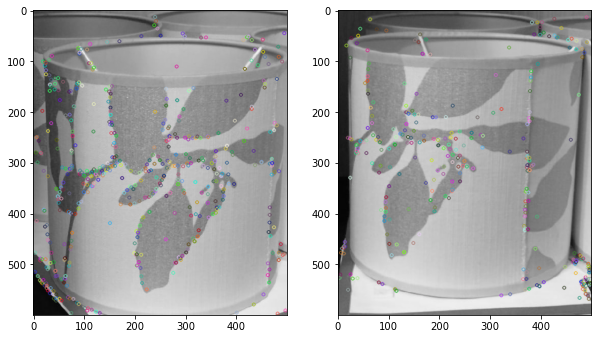

In [63]:
fig, ax = plt.subplots( 1, 2, figsize = (10, 10) )
kp_im1 = cv2.drawKeypoints( im1_main, kpts, im1_main.copy())
kp_im2 = cv2.drawKeypoints( im2_main, kpts2, im1_main.copy())
ax[0].imshow( kp_im1, cmap = 'gray' )
ax[1].imshow( kp_im2, cmap = 'gray' )

#### Brute-force matcher ####

Создание экземпляра Brute-force матчера для сопоставления точек, который будет искать похожие дескрипторы у двух изображений.

In [64]:
bfm = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

In [65]:
# применение и сопоставление точек
match = bfm.match(desc, desc2)

После получения множества точек, надо посмотреть, какие из дескрипторов ближе друг к другу, а какие дальше, т.е. найти лучшие краевые точки.

In [66]:
# Для этого применяется сортировка по расстоянию
bst_match = sorted(match, key = lambda x:x.distance, reverse = False)
# от лучших к худшим

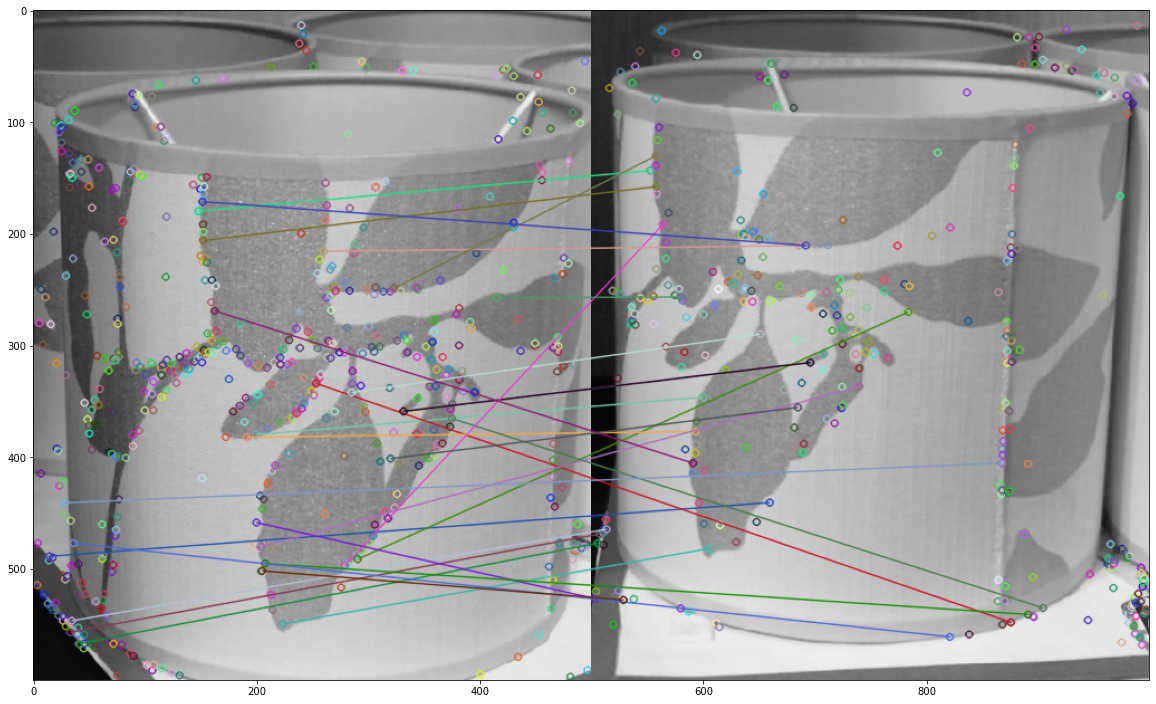

In [67]:
fig = plt.figure(figsize = (20, 20) )
res = cv2.drawMatches(im1_main, kpts, im2_main, kpts2, bst_match[:28], im2_main)
plt.imshow(res);

28 точек, многие из них не очень хорошо легли.

In [68]:
print('Ошибка составила {}'.format((sum([i.distance for i in bst_match[:28]])/len(bst_match[:28])) ** .5))

Ошибка составила 24.703961509962614


#### BFMatcher.knnMatch (), чтобы получить k лучших совпадений. ####

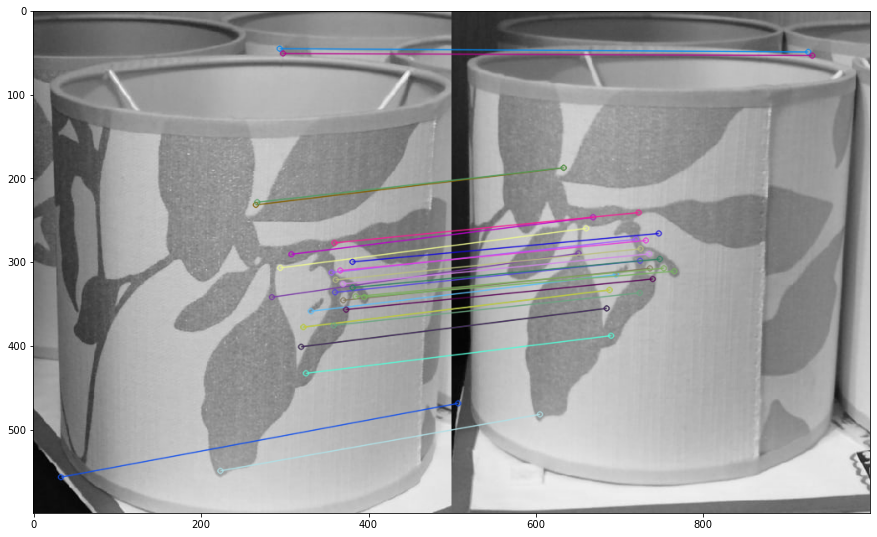

In [69]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc, desc2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.51*n.distance: # при 0.52 и более начинает ошибаться
        good.append([m])

img3 = cv2.drawMatchesKnn(im1_main,kpts,im2_main,kpts2,good,flags=2, outImg = im2_main)
fig = plt.figure(figsize = (15,15))
plt.imshow(img3)
plt.show()

Тоже 28 точек, значит можно сравнить корень из ошибки.

In [70]:
print('Ошибка составила {}'.format((sum([i[0].distance for i in good])/len(good)) ** .5))

Ошибка составила 11.419581943683125


Видно, что работает намного лучше.

#### FLANN - алгоритм ####

Еще нашел на просторах документации opencv такой алгоритм, который ищет по ближайшим соседям.
FLANN - Fast Library for Approximate Nearest Neighbors.

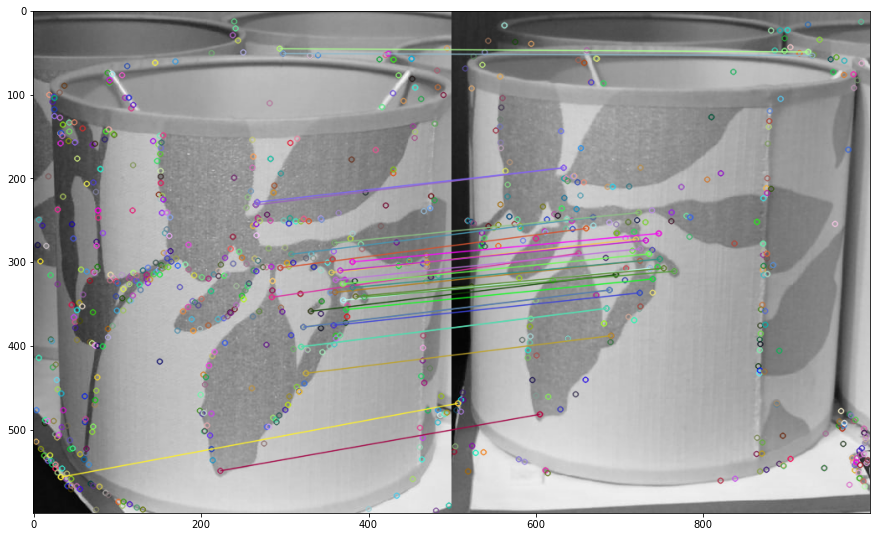

In [71]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE)
search_params = {} 

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(desc,desc2, k=2)

good_flann = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.51*n.distance:
        good_flann.append([m])

img4 = cv2.drawMatchesKnn(im1_main,kpts,im2_main,kpts2,good_flann,outImg = im2_main)
fig = plt.figure(figsize = (15,15))
plt.imshow(img4)

In [72]:
print('Ошибка для FLANN составила {}'.format((sum([i[0].distance for i in good_flann])/len(good_flann)) ** .5))

Ошибка для FLANN составила 11.419581943683125


Тоже самое, а работает быстрее.

#### RANSAC и гомография ####

Можно попробовать поиграться с гомографией и Ransac.

In [73]:
# здесь точки заданы изначально
def find_homography():
    #pts1 -> pts2
    pts1 = np.array([[150, 150],
                     [460, 540],
                     [230, 550],
                     [460, 300]])
    pts2 = np.array([[50, 100],
                     [380, 540],
                     [100, 490],
                     [380, 280]])
    # расчет гомографии
    h, status = cv2.findHomography(pts1, pts2, cv2.RANSAC)
    # выходное изображение
    im_out = cv2.warpPerspective(im1_main, h, (im2_main.shape[1],im2_main.shape[0]))
    fig, ax = plt.subplots(3,1, figsize = (10,10))

    ax[0].imshow(im1_main)
    ax[0].scatter(pts1[:,0], pts1[:,1])
    ax[1].imshow(im2_main)
    ax[1].scatter(pts2[:,0], pts2[:,1])
    ax[2].imshow(im_out)

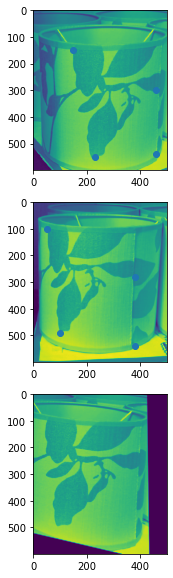

In [74]:
find_homography()

По изначально заданным точкам все работет нормально.

Но можно попробовать перебирать точки из набора, полученного из SIFT так, чтобы разница между вторым изображением и трансформированным первым была минимальна.

In [75]:
# Чтобы нормально работать с точками keypoints, лучше их извлечь и перевести в нормальный формат
coord1 = [i.pt for i in kpts]
coord2 = [i.pt for i in kpts2]
desc1 = desc.copy()
desc2 = desc2.copy()

In [76]:
len(coord1), desc1.shape

(541, (541, 128))

In [77]:
a = [0,5]
b = [1,0]
1 - distance.cosine(a,b)

0.0

In [78]:
def find_random_homography(n_iter = 100):
    #pts1 -> pts2
    rng = np.random.default_rng(0)
    max_d = 0
    for _ in range(n_iter):
        # генерация 4-х случайных точек
        # для первого изображения
        i00 = rng.integers( len(coord1) )
        i01 = rng.integers( len(coord1) )
        i02 = rng.integers( len(coord1) )
        i03 = rng.integers( len(coord1) )
        p1 = np.array(coord1[ i00 ])
        p2 = np.array(coord1[ i01 ])
        p3 = np.array(coord1[ i02 ])
        p4 = np.array(coord1[ i03 ])
        # для второго изображения
        i10 = rng.integers( len(coord2) )
        i11 = rng.integers( len(coord2) )
        i12 = rng.integers( len(coord2) )
        i13 = rng.integers( len(coord2) )
        p5 = np.array(coord1[ i10 ])
        p6 = np.array(coord1[ i11 ])
        p7 = np.array(coord1[ i12 ])
        p8 = np.array(coord1[ i13 ])
        
        # объединение для первого и второго
        pts1 = np.array([p1,p2,p3,p4])
        pts2 = np.array([p5,p6,p7,p8])
        
        # расчет гомографии
        h, status = cv2.findHomography(pts1, pts2, cv2.RANSAC)
        
        # выходное изображение
        im_out = cv2.warpPerspective(im1_main, h, (im2_main.shape[1],im2_main.shape[0]))
        # далее надо сравнить получившееся и выходное
        # косинусное r измеряет только 1-D векторы, так что вытягиваем картинки
        im1_flat = im1_main.flatten() 
        im_out_flat = im_out.flatten()
        # считаем r
        cosin_d = 1 - distance.cosine(im1_flat, im_out_flat) # перевод в близость
        # ищем максимум близости: 0 - отличаются, 1 - близки
        if (cosin_d > max_d):
            max_d = cosin_d
            pts_1_res = pts1
            pts_2_res = pts2
            res_im_out = im_out.copy()
            
    fig, ax = plt.subplots(3,1, figsize = (10,10))
    ax[0].imshow(im1_main)
    ax[0].scatter(pts_1_res[:,0], pts_1_res[:,1])
    ax[1].imshow(im2_main)
    ax[1].scatter(pts_2_res[:,0], pts_2_res[:,1])
    ax[2].imshow(res_im_out)

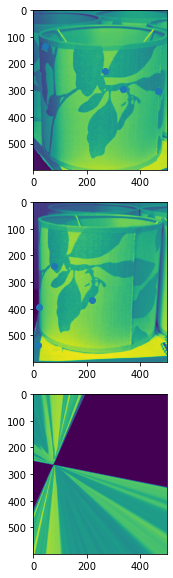

In [79]:
find_random_homography(n_iter = 500)

Ну, довольно логично, что вероятность того, что 4-ре правильные точки попадут очень низка, так что такой способ работать не будет.
Но, как упражнение просто поиграться.

### Можно попробовать в реальном времени ###

In [80]:
path = "video.mp4"

In [81]:
def process_video(path: str = "video.mp4", speed: int = 5, best_n: int = 20) -> None:
    """Сравнение предыдущего и текущего кадра"""
    # Читаем файл с видео
    cap = cv2.VideoCapture(path)
    # создаем sift
    sift = cv2.SIFT_create()
    # настраиваем параметры flann и создаем экземпляр класса
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    while True:
        return_1, frame_1 = cap.read()
        return_2, frame_2 = cap.read()
        
        # проверка прочтения кадра
        if (return_1 == False or return_2 == False):
            break
        
        frame_1 = cv2.resize(frame_1, (300, 500))
        frame_2 = cv2.resize(frame_2, (300, 500))
        
        
        frame1 = cv2.cvtColor( frame_1, cv2.COLOR_RGB2GRAY)
        frame2 = cv2.cvtColor( frame_2, cv2.COLOR_RGB2GRAY)
        
        kpts, desc = sift.detectAndCompute( frame1, None) # -> keypoints, descriptors
        kpts2, desc2 = sift.detectAndCompute( frame2, None)


        matches = flann.knnMatch(desc,desc2, k=2)
        
        sorted(matches, key = lambda x:x[0].distance, reverse = False)
        
        res = cv2.drawMatchesKnn(frame1, kpts, 
                                 frame2, kpts2,
                                 matches[:best_n], flags=2, outImg = frame2)
        
        cv2.imshow('frame', res)
        if cv2.waitKey(speed) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [84]:
process_video(path = path, speed = 10)